## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

In this project, we will be working to understand the results of an A/B test run by an e-commerce website.  Our goal is to work  to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import the required libraries.

In [158]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
random.seed(42)

`1.` Now, read in the `ab_data.csv` data and Store it in `df`.  

a. Read in the dataset and take a look at the top few rows here:

In [159]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. The dataset shape?

In [160]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [161]:
df.user_id.nunique()

290584

d. The proportion of users converted. (converted means those who clicked on the page)

In [162]:
df[df['converted']==1].shape[0]/df.user_id.nunique()

0.12126269856564711

e. The number of times the `new_page` and `treatment` don't line up.

In [163]:
selection1=df.loc[(df.group=='treatment')&(df.landing_page!='new_page')].count()+df.loc[(df.group!='treatment')&(df.landing_page=='new_page')].count()
selection1[0]

3893

f. Do any of the rows have missing values?

In [164]:
df.isnull().sum()[0]

0

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  
a. Now we create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [165]:
df2=df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True].copy()
df2.shape

(290585, 5)

In [166]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].count()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`3.` We use **df2** and the cells below to answer the follwoing questions

a. How many unique **user_id**s are in **df2**?

In [167]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [168]:
df2[df2['user_id'].duplicated(keep=False)]['user_id'].values[0]

773192

c. What is the row information for the repeat **user_id**? 

In [169]:
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep the dataframe as **df2**.

In [170]:
df2.reset_index(inplace=True)
df2.drop(df2.index[df2[df2['user_id'].duplicated(keep=False)]['user_id'].index.values[:-1]], inplace=True);


`4.` Use **df2** in the below cells to answer more questions

a. What is the probability of an individual converting regardless of the page they receive?

In [171]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [172]:
df2[df2['group']=='control']['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [173]:
df2[df2['group']=='treatment']['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [174]:
df2[df2['landing_page']=='new_page'].shape[0]/df.shape[0]

0.4934494257635545

In [175]:
df2[df2['landing_page']=='new_page']['converted'].mean()

0.11880806551510564

In [176]:
df2[df2['landing_page']=='old_page'].shape[0]/df.shape[0]

0.4933271755445229

In [177]:
df2[df2['landing_page']=='old_page']['converted'].mean()

0.1203863045004612

In [178]:
df2.head()

,index,user_id,timestamp,group,landing_page,converted
0,0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,4,864975,2017-01-21 01:52:26.210827,control,old_page,1


<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` We consider that we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should our null and alternative hypotheses be?  We can state our hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$H_{0}=$  $p_{old}>p_{new}$ **

**$H_{1}=$  $p_{new}>p_{old}$ **

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>
Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>
Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [179]:
p_new=df2.query('converted==1').user_id.count()/df.shape[0]
p_new

0.11801560727796304

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [180]:
p_old=df2.query('converted==1').user_id.count()/df.shape[0]
p_old

0.11801560727796304

c. What is $n_{new}$?

In [181]:
n_new=df2[df2['group']=='treatment'].user_id.nunique()
n_new

145310

d. What is $n_{old}$?

In [182]:
n_old=df2[df2['group']=='control'].user_id.nunique()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [183]:
new_page_converted = np.random.binomial(1,p_new,n_new)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [184]:
old_page_converted = np.random.binomial(1,p_old,n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [185]:
pnew = new_page_converted.sum()/len(new_page_converted)
pold = old_page_converted.sum()/len(old_page_converted)
diff = pnew - pold

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [186]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(1,p_new,n_new)
    old_page_converted = np.random.binomial(1,p_old,n_old)
    pnew = new_page_converted.sum()/len(new_page_converted)
    pold = old_page_converted.sum()/len(old_page_converted)
    p_diffs.append(pnew-pold)


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  

Text(0.5,1,'Histogram of p_diffs')

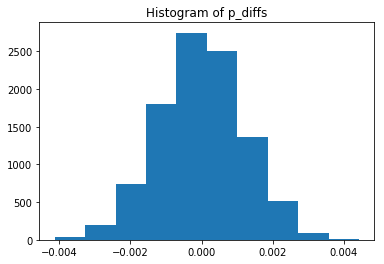

In [187]:
plt.hist(p_diffs);
plt.title('Histogram of p_diffs')

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

0.8906


Text(0.5,1,'Histogram of p_diffs')

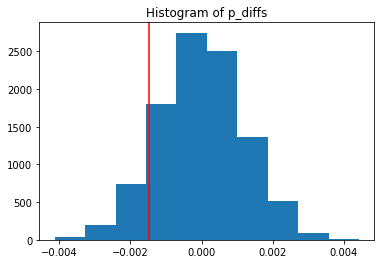

In [188]:
p_diffs=np.array(p_diffs)
pold_actual = df[df['group']=='control']['converted'].mean()
pnew_actual = df[df['group']=='treatment']['converted'].mean()
f_actual = pnew_actual - pold_actual
print((p_diffs>f_actual).mean())
plt.hist(p_diffs);
plt.axvline(x=p_diff_actual, color='red');
plt.title('Histogram of p_diffs')

k. We explain what we just computed in part **j.**

**with p_value=0.889>0.05, it's likely our statistics are from null.**

**We have computed the p-value which we can use to assess if the obtained negative p_diff(pnew-pold) is statistically significant. A negative p_diff proves that null hypothesis is valid based on our definition of null (New is not better). Initially, after bootstrapping we obtained a distribution for p_diff centered at -0.001 which tends to show that null is valid. But, comparing that to null random normal distribution shows that there is a high chance that this negative value is drawn from a null random process (large p-value). Therefore, this negative value for p_diff is not statistically significant. Thus, null is rejected and  New is better. **

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. We calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [189]:
import statsmodels.api as sm

convert_old = df2[(df2['group']=='control')&(df2['converted']==1)]['user_id'].count()
convert_new = df2[(df2['group']=='treatment')&(df2['converted']==1)]['user_id'].count()
n_old = df2[df2['group']=='control'].user_id.nunique()
n_new = df2[df2['group']=='treatment'].user_id.nunique()

In [190]:
convert_old,convert_new,n_old,n_new

(17489, 17264, 145274, 145310)

m. We now use `stats.proportions_ztest` to compute the test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [191]:
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new], [n_old,n_new],value=None, alternative='smaller', prop_var=False)
print(z_score,p_value)


1.31092419842 0.905058312759


**The obtained p-value (.894) agrees with what we obtained in part j (.890) indicatig that the null hypothesis (New not better) is rejected. z-score is the number of standard deviations the observed conversion rate is away from the mean. This agrees with the conclusion we made in part k **

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result we acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression**

b. The goal is to use **statsmodels** to fit the regression model we specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, our first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [192]:
df2[['control','ab_page']]=pd.get_dummies(df2['group'])
df2.head()

,index,user_id,timestamp,group,landing_page,converted,control,ab_page
0,0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1
3,3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1
4,4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. we use **statsmodels** to import our regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [193]:
df2['intercept']=1
model=sm.Logit(df2['converted'],df2[['intercept','ab_page']])
result=model.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [194]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 24 Mar 2018   Pseudo R-squ.:               8.077e-06
Time:                        14:39:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br> 

**In our logistic regression model, the null hypothesis is that the coefficient of ab_page is nagative. This means that, under null, an increase in ab_page (using new page) results in decrease of conversion. In other words, under null, new page is NOT better:**

$H_{0}: $  $coeff_{ab- page}<0$

**Fitting a logistic regression model with Logit, we obtain this coefficient to be -0.015 which tends to show that null is valid. But, the p-value associated with this coefficient is large (0.190) which shows that the negative coefficient obtained for ab_page is not statistically significant. Therefore, null is rejected, and new page is better **

f. Now, we are considering other things that might influence whether or not an individual converts. 

**Here we used only one variable (membership in control or treatment groups) to draw a conclusion about the conversion rate. In real life, there might be other effective parameters for example gender of user, age, etc. Current dataset does not contain this information, but adding them may help to draw a better conclusion. A possible disadvantage is that if more variables are going to be added, more data points should be collected as well to maintain a reach dataset. Moreover, adding new variables should be done cauciously to avoid adding correlated variables that violates the assumptions of linear regression. **

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. We will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** 

In [195]:
df_country=pd.read_csv('countries.csv')
df_country.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [196]:
df2=df2.set_index('user_id').join(df_country.set_index('user_id'))

In [197]:
df2[['US','UK','CA']]=pd.get_dummies(df2['country'])
df2.head()

,index,timestamp,group,landing_page,converted,control,ab_page,intercept,country,US,UK,CA
user_id,,,,,,,,,,,,
851104,0,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,US,0,0,1
804228,1,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,US,0,0,1
661590,2,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1,US,0,0,1
853541,3,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1,US,0,0,1
864975,4,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,US,0,0,1


In [198]:
df2['intercept']=1
model=sm.Logit(df2['converted'],df2[['intercept','ab_page','US','UK']])
result=model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 24 Mar 2018   Pseudo R-squ.:               2.323e-05
Time:                        14:39:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

**Based on the result we se that US has the negative impact on conversion rate and UK has positive impact, but amount of p-values in both show that the coefficients are not stastically significant  **

h. Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

In [199]:
df2['US_ind'] = df2['US']*df2['ab_page']
df2['UK_ind'] = df2['UK']*df2['ab_page']
model=sm.Logit(df2['converted'],df2[['intercept','ab_page','US','UK','US_ind','UK_ind']])
result=model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 24 Mar 2018   Pseudo R-squ.:               3.482e-05
Time:                        14:39:22   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
US            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
US_ind        -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_ind         0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

**Here we see that based on our model all the variables other than UK have negative impact in our conversion rate and UK has positive effect, but by looking at the p_value we find that our results are not statistically significant **

<a id='conclusions'></a>
## Conclusions

**This project is a sample of Simpson's Paradox, because by the first glimpse at the data, we can conclude that the conversion rate for old page is more than new page  so it is better to stay. 
But by doing haypothesis testing and logistic regression model we can see completely different results and based on them we can conclude that the new page has better performance.**
